In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as T
from torch import Tensor

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from PIL import Image

import os

print(os.getcwd()) # dosya yolunu ver
%run ../Model.ipynb
%run ../Dataset.ipynb

%run ./Flow_Model.ipynb

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

/arf/home/tunal/ondemand/PhD Thesis Starting/01_SON/Tik-4/Tez/08-CelebA-Copy2/05-UAE_Latent_FM


In [2]:
# Veri yolu
root_dir = '../data/img_align_celeba/'
test_dataset  = CelebADataset(img_dir=root_dir, attr_path='../data/list_attr_celeba.csv', partition_path='../data/list_eval_partition.csv', mode='test')
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset))

In [3]:
# UAE modelini çalıştır

path = '../02-UAE_for_CelebA/results/UAE_CelebA_HQ'
model = torch.load(path + '.model', weights_only=False, map_location='cpu')
model.eval()

To_Uniform(
  (encoder): SimpleEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Sequential(
      (0): Linear(in_features=8192, out_features=2048, bias=True)
      (1): SiLU

In [5]:
# "results" klasörünü oluştur (zaten varsa hata vermez)
os.makedirs("results", exist_ok=True)

flow_name = './results/UAE_Latent_FM'
model_eval = torch.load(flow_name + '.model', weights_only=False, map_location='cpu')
model_eval.eval()

Flow(
  (net): Sequential(
    (0): Linear(in_features=1025, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=1000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1000, out_features=1000, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1000, out_features=1024, bias=True)
  )
)

In [6]:
# Kayıpları yükle
"""
losses = np.loadtxt("results/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Grafik oluştur
plt.plot(val_losses, label="Ortalama doğrulama kaybı", c="red")
plt.plot(train_losses, label="Ortalama eğitim kaybı", c="blue")

plt.xlabel("Epok")
plt.ylabel("Ortalama Kayıp")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("results/average_losses_per_epoch.pdf")
plt.show()
"""

'\nlosses = np.loadtxt("results/losses.csv", delimiter=",", skiprows=1)\ntrain_losses = losses[:, 0]\nval_losses = losses[:, 1]\n\n# Grafik oluştur\nplt.plot(val_losses, label="Ortalama doğrulama kaybı", c="red")\nplt.plot(train_losses, label="Ortalama eğitim kaybı", c="blue")\n\nplt.xlabel("Epok")\nplt.ylabel("Ortalama Kayıp")\nplt.legend(loc=\'upper right\', fontsize=16)\n\nplt.tight_layout()\nplt.savefig("results/average_losses_per_epoch.pdf")\nplt.show()\n'

In [7]:
# Initialize uniform random data (3D)
x_uniform = torch.rand(len(test_dataset), 1024)
n_steps = 8

# Create time steps
time_steps = torch.linspace(0, 1.0, n_steps + 1)


for i in range(n_steps):
    x_uniform = model_eval.step(x_t=x_uniform, t_start=time_steps[i], t_end=time_steps[i + 1])

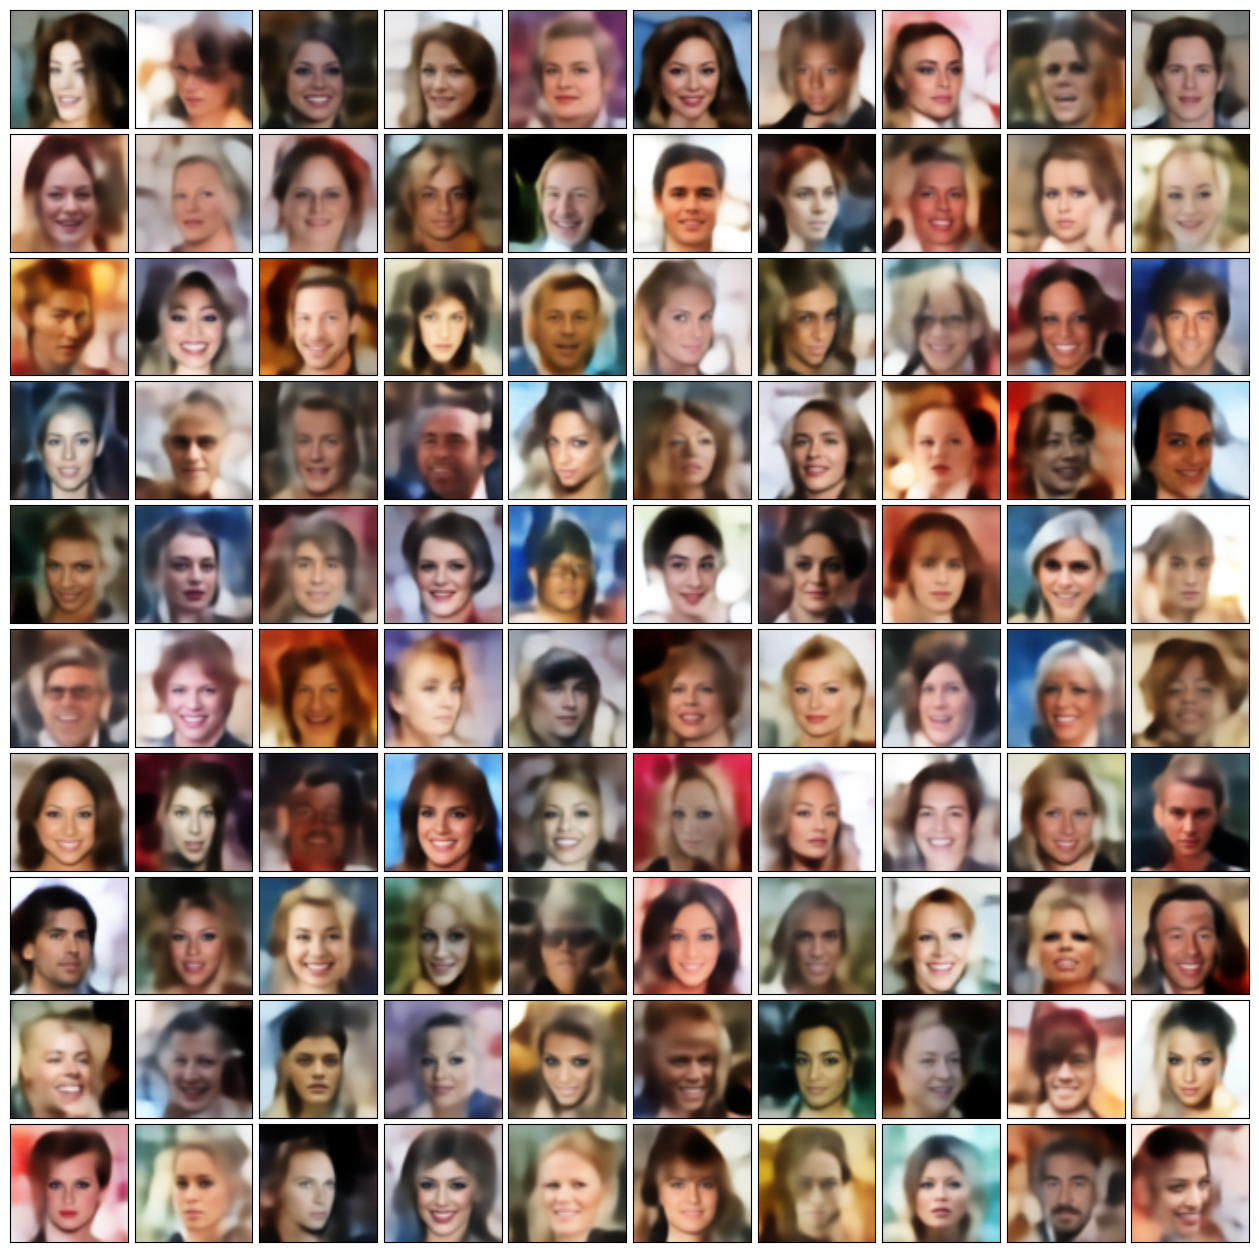

In [8]:
# Decode et
x_hat = model.decoder(x_uniform).view(-1, 3, 64, 64)

# Görselleştir
fig, axs = plt.subplots(10, 10, figsize=(16, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i, ax in enumerate(axs.flat):
    img = x_hat[i].reshape(3, 64, 64).permute(1, 2, 0).detach().numpy()
    ax.imshow(img, interpolation='bilinear')

plt.savefig('./results/celebA_HQ_veri_uretimi_from_latent_FM.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

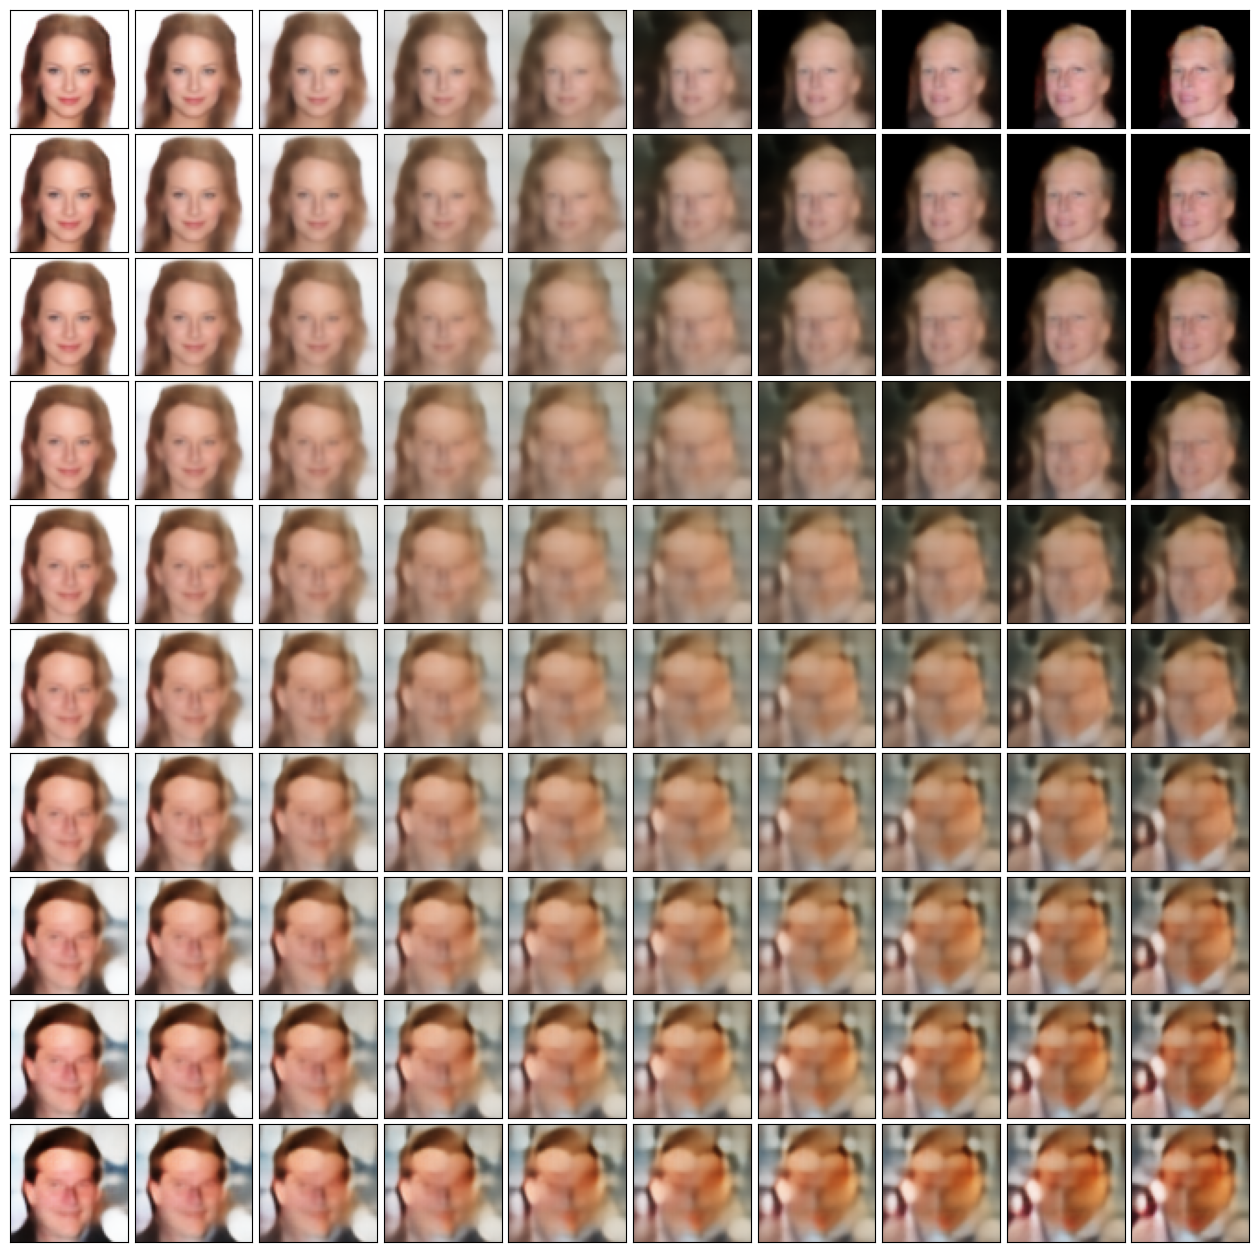

In [12]:
from itertools import product

device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs("results", exist_ok=True)

# 1. 4 rastgele test örneği seç
idx = torch.randint(0, len(test_dataset), (4,))
x1 = model.encoder(test_dataset[idx[0]].unsqueeze(0).to(device))  # top-left
x2 = model.encoder(test_dataset[idx[1]].unsqueeze(0).to(device))  # top-right
x3 = model.encoder(test_dataset[idx[2]].unsqueeze(0).to(device))  # bottom-left
x4 = model.encoder(test_dataset[idx[3]].unsqueeze(0).to(device))  # bottom-right

# 2. Bilinear interpolasyon fonksiyonu
def bilinear_interp(z_tl, z_tr, z_bl, z_br, x, y):
    return (
        (1 - x) * (1 - y) * z_tl +
        x * (1 - y) * z_tr +
        (1 - x) * y * z_bl +
        x * y * z_br
    )

# 3. Interpolasyon grid’i oluştur
n_steps = 10
grid_z = []
time_steps = torch.linspace(0, 1.0, 9).to(device)

for i, j in product(range(n_steps), range(n_steps)):
    xi = j / (n_steps - 1)
    yi = i / (n_steps - 1)
    z = bilinear_interp(x1, x2, x3, x4, xi, yi)  # [1, latent_dim]

    # Flow çözümü
    z_interp = z.clone()
    for k in range(len(time_steps) - 1):
        z_interp = model_eval.step(x_t=z_interp, t_start=time_steps[k], t_end=time_steps[k + 1])

    grid_z.append(z_interp)

# 4. Decode et ve görselleştir
fig, axes = plt.subplots(n_steps, n_steps, figsize=(16, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i in range(n_steps):
    for j in range(n_steps):
        index = i * n_steps + j
        decoded_img = model.decoder(grid_z[index]).squeeze(0).cpu().permute(1, 2, 0).clip(0, 1)
        axes[i, j].imshow(decoded_img.detach().numpy())

plt.savefig('./results/celeba64_flow_corner_interp.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Rasgele uniform dağılımdan alınan sample lar ile interpolasyon

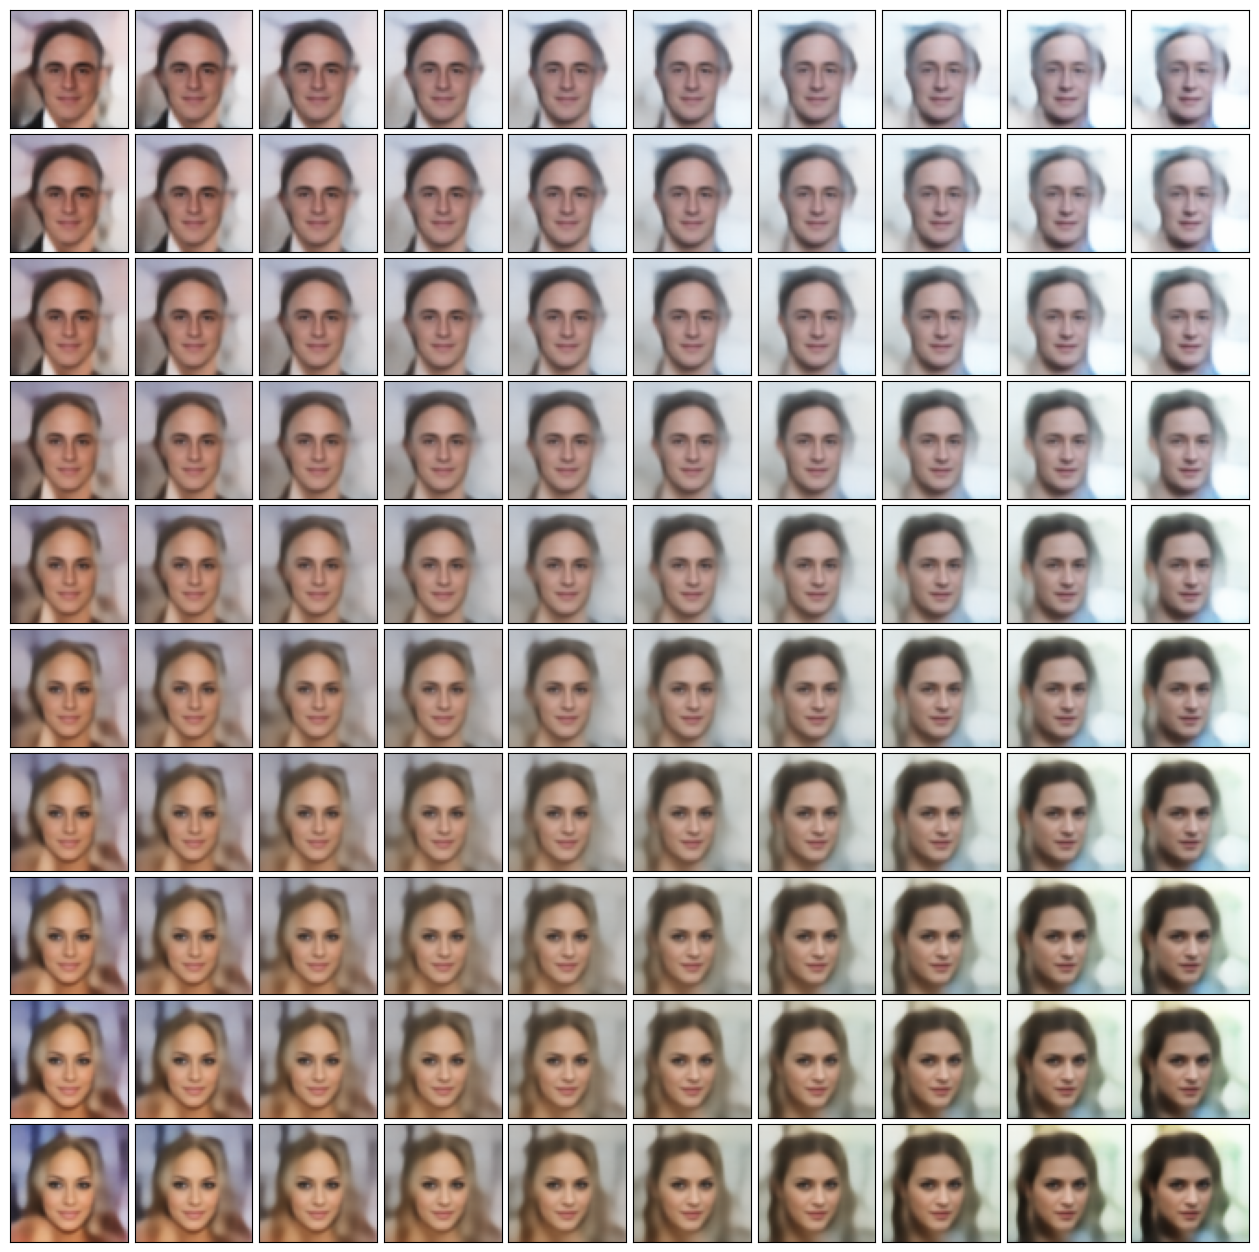

In [10]:
from itertools import product
import torch
import matplotlib.pyplot as plt

# Cihaz
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Rastgele 4 latent vektör üret (örneğin latent_dim=300)
latent_dim = 1024  # encoder çıktısına göre değiştirin
z_tl = torch.rand(1, latent_dim, device=device)  # Top-left
z_tr = torch.rand(1, latent_dim, device=device)  # Top-right
z_bl = torch.rand(1, latent_dim, device=device)  # Bottom-left
z_br = torch.rand(1, latent_dim, device=device)  # Bottom-right

# 2. Bilinear interpolasyon fonksiyonu
def bilinear_interp(z_tl, z_tr, z_bl, z_br, x, y):
    return (
        (1 - x) * (1 - y) * z_tl +
        x * (1 - y) * z_tr +
        (1 - x) * y * z_bl +
        x * y * z_br
    )

# 3. Interpolasyon + (varsa) flow çözümü
n_steps = 10
grid_z = []

time_steps = torch.linspace(0, 1.0, 9).to(device)

for i, j in product(range(n_steps), range(n_steps)):
    xi = j / (n_steps - 1)
    yi = i / (n_steps - 1)
    z = bilinear_interp(z_tl, z_tr, z_bl, z_br, xi, yi)

    # (isteğe bağlı) flow çözümü
    z_interp = z.clone()
    for k in range(len(time_steps) - 1):
        z_interp = model_eval.step(x_t=z_interp, t_start=time_steps[k], t_end=time_steps[k + 1])

    grid_z.append(z_interp)

# 4. Decode edip görselleştir (64x64 RGB)
fig, axes = plt.subplots(n_steps, n_steps, figsize=(16, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i in range(n_steps):
    for j in range(n_steps):
        index = i * n_steps + j
        decoded_img = model.decoder(grid_z[index]).squeeze(0).cpu()
        decoded_img = decoded_img.permute(1, 2, 0).clip(0, 1)  # [3,64,64] -> [64,64,3]
        axes[i, j].imshow(decoded_img.detach().numpy())


plt.savefig('./results/celeba_uniform_corner_interp_grid.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()